In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tfcvnn as cvnn

In [2]:
# Example usage: Build a simple model with the custom complex dense layer
n = 10
m = 100
train_complex = False
activation = cvnn.activations.ComplexModLeakyReLU
layer = cvnn.layers.ComplexDense


inputs = tf.keras.Input(shape=(n,), dtype=tf.complex64)
x = layer(20)(inputs)
x = activation()(x)
x = layer(50)(inputs)
x = activation()(x)
# # x = ComplexDense(100)(x)
outputs = layer(m)(x)
outputs = activation()(outputs)

# outputs = ComplexDense(m)(inputs)
if train_complex:
    outputs = tf.abs(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 complex_dense_1 (ComplexDen  (None, 50)               1100      
 se)                                                             
                                                                 
 complex_mod_leaky_re_lu_1 (  (None, 50)               0         
 ComplexModLeakyReLU)                                            
                                                                 
 complex_dense_2 (ComplexDen  (None, 100)              10200     
 se)                                                             
                                                                 
 complex_mod_leaky_re_lu_2 (  (None, 100)              0         
 ComplexModLeakyReLU)                                        

In [ ]:
# Example usage
input_shape = (None, 64, 64, 3)  # Batch size, height, width, channels
inputs = tf.keras.Input(shape=input_shape[1:], dtype=tf.complex64)

x = ComplexConv2D(32, kernel_size=(3, 3), padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)  # Activation can be applied to complex values

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

In [3]:
N = 3000
TM = np.random.rand(m, n) * np.exp(1j * 2 * np.pi * np.random.rand(m, n))
TM = TM * np.expand_dims(np.exp(-1j * np.angle(TM[0, :])), axis=0)
X = np.random.rand(N, n) * np.exp(1j * 2 * np.pi * np.random.rand(N, n))
Y = (TM @ X.T).T

print(Y.shape)
print(X.shape)

(3000, 100)
(3000, 10)


In [4]:
x_tf = tf.cast(tf.convert_to_tensor(X), tf.complex64)
y_tf = tf.cast(tf.convert_to_tensor(Y), tf.complex64)
batch_size = 32
validation_split = 0.2

num_samples = x_tf.shape[0]
num_val_samples = int(validation_split * num_samples)

# Shuffle and split the data into training and validation sets
dataset = tf.data.Dataset.from_tensor_slices((x_tf, tf.abs(y_tf) if train_complex else y_tf))
dataset = dataset.shuffle(buffer_size=num_samples)

# Create training and validation datasets
train_dataset = dataset.skip(num_val_samples).batch(batch_size)
val_dataset = dataset.take(num_val_samples).batch(batch_size)

# Compile the model with a complex loss function
reduce_lr_callback_params = dict(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6, cooldown=2, min_delta=0.1, verbose=1,)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_callback_params)

adam_params = dict(learning_rate=1e-2, beta_1=0.9)
optimizer = tf.keras.optimizers.Adam(**adam_params)

model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[reduce_lr_callback])


Epoch 1/30
75/75 [==============================] - 1s 9ms/step - loss: 0.1170 - val_loss: 3.3083e-04 - lr: 0.0100
Epoch 2/30
75/75 [==============================] - 1s 8ms/step - loss: 5.3266e-05 - val_loss: 4.0546e-07 - lr: 0.0100
Epoch 3/30
75/75 [==============================] - 1s 8ms/step - loss: 6.5825e-08 - val_loss: 6.6911e-10 - lr: 0.0100
Epoch 4/30
75/75 [==============================] - 1s 8ms/step - loss: 1.2535e-10 - val_loss: 2.2622e-12 - lr: 0.0100
Epoch 5/30
75/75 [==============================] - 1s 8ms/step - loss: 4.6271e-13 - val_loss: 7.1932e-14 - lr: 0.0100
Epoch 6/30
75/75 [==============================] - 1s 9ms/step - loss: 6.0685e-14 - val_loss: 5.9082e-14 - lr: 0.0100
Epoch 7/30
75/75 [==============================] - 1s 9ms/step - loss: 6.0104e-14 - val_loss: 6.2475e-14 - lr: 0.0100
Epoch 8/30
75/75 [==============================] - 1s 9ms/step - loss: 6.3312e-14 - val_loss: 6.5738e-14 - lr: 0.0100
Epoch 9/30
75/75 [==============================] - 

ValueError: operands could not be broadcast together with shapes (10,50) (10,100) 

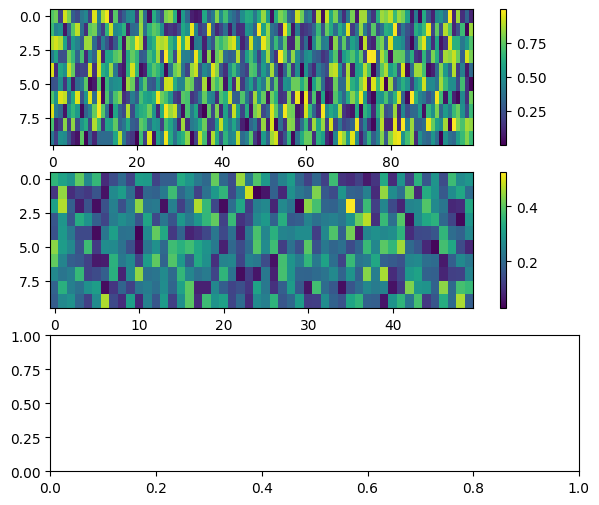

In [5]:
TMR = model.weights[0].numpy() + 1j * model.weights[1].numpy()
TMR = TMR * np.expand_dims(np.exp(-1j * np.angle(TMR[0, :])), axis=-0)

plt.figure(figsize=(15, 6))

plt.subplot(3, 2, 1)
plt.imshow(np.abs(TM.T))
plt.colorbar()
plt.axis('auto')

plt.subplot(3, 2, 3)
plt.imshow(np.abs(TMR))
plt.colorbar()
plt.axis('auto')

plt.subplot(3, 2, 5)
plt.imshow(np.abs(TMR) - np.abs(TM.T))
plt.colorbar()
plt.axis('auto')

plt.subplot(3, 2, 2)
plt.imshow(np.angle(TM.T))
plt.colorbar()
plt.axis('auto')

plt.subplot(3, 2, 4)
plt.imshow(np.angle(TMR))
plt.colorbar()
plt.axis('auto')

plt.subplot(3, 2, 6)
plt.imshow(np.angle(np.exp(1j * (np.angle(TMR) - np.angle(TM.T)))))
plt.colorbar()
plt.axis('auto')